Clone the repository

In [1]:
try:
    ! git clone https://github.com/cs612-smu/cs612-smu-2025 CS612_SMU
    HOME_DIR = "./CS612_SMU/week2/"
except:
    print('Already clone!!!')

fatal: destination path 'CS612_SMU' already exists and is not an empty directory.


Exercise 2a: This following is an implementation of the FGSM attach that is untargeted.

In [20]:
# This is an implementation of FGSM, an untargeted attack


import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import numpy as np
import ast


class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x # cross entropy in pytorch already includes softmax
        return output


def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name))

    return model


def denormalize(x):
    x = (x * 255).astype('uint8')
    x = x.reshape(28,28)

    return x


def display(x, y, x_adv, y_adv):
    x = denormalize(x)
    x_adv = denormalize(x_adv)

    fig, ax = plt.subplots(1, 2)

    ax[0].set(title='Original. Label is {}'.format(y))
    ax[1].set(title='Adv. sample. Label is {}'.format(y_adv))

    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(x_adv, cmap='gray')

    plt.show()


def fgsm(model, x, y, eps): #x is the sample, y is its original label; eps is the attacking budget
    x_adv = x.detach().clone()
    x_adv.requires_grad = True

    pred = model(x_adv)
    loss = F.cross_entropy(pred, y)

    loss.backward()

    grad_data = x_adv.grad.data
    #The following line of code is the essence of FGSM.
    #That is, we update x_adv (initially an exact copy of x) by updating its pixel values according to the gradient.
    #Note that grad_data is the gradient obtained based on the loss above.
    #The following line thus effectively increases the loss of the original label.
    x_adv = torch.clamp(x_adv + eps * grad_data.sign(), 0, 1).detach()

    pred_adv = model(x_adv) #get the prediction of x'
    y_adv = pred_adv.argmax(1) #get the label of x'

    if y_adv != y:
        x = x.detach().numpy().reshape(-1)
        x_adv = x_adv.detach().numpy().reshape(-1)

        y, y_adv = y.item(), y_adv.item()

        print('Attack successful: Found an adversarial sample!\n')

        #print('pred adv = {}'.format(pred_adv.detach().numpy().reshape(-1)))
        #print('lbl adv = {}\n'.format(y_adv))

        display(x, y, x_adv, y_adv)
        return True
    else:
        print('Attack unsuccessful.\n')
        return False


model = load_model(MNISTNet, HOME_DIR + 'exercise2/mnist.pt')
num_adv, eps = 0, 0.01 #vary eps to see the effect

labels = np.array(ast.literal_eval(open(HOME_DIR + 'exercise2/toattack/labels.txt', 'r').readline()))

num_attack = 5
print('Initiating FGSM untargeted Attack on {} images.\n'.format(num_attack ))
for i in range(num_attack):

    file_name = HOME_DIR + 'exercise2/toattack/data' + str(i) + '.txt'
    x = np.array(ast.literal_eval(open(file_name, 'r').readline()))
    x = torch.Tensor(x)
    y = torch.Tensor([labels[i]]).type(torch.LongTensor)

    pred = model(x)
    #print('pred img = {}'.format(pred.detach().numpy().reshape(-1)))
    #print('lbl imp = {}\n'.format(y.item()))

    if fgsm(model, x, y, eps): num_adv += 1

print('{} of the {} attacks are successful.'.format(num_adv, num_attack))


Initiating FGSM untargeted Attack on 5 images.

Attack unsuccessful.

Attack unsuccessful.

Attack unsuccessful.

Attack unsuccessful.

Attack unsuccessful.

0 of the 5 attacks are successful.


Exercise 2b: In this exercise, you are asked to modify the FGSM attack method so that it becomes a targeted attack.

Initiating FGSM targeted Attack on 5 images with target 7.

Attacking a new image.
The sample is already classified as the target! Skip the sample.

Attacking a new image.
Attack unsuccessful.

Attacking a new image.
Attack unsuccessful.

Attacking a new image.
Attack unsuccessful.

Attacking a new image.
Attack successful: Found an adversarial sample!



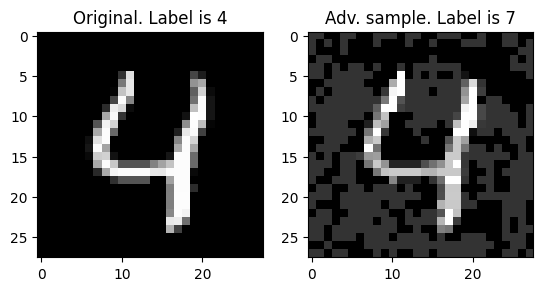

1 of the 5 attacks are successful.


In [16]:
# This is an implementation of FGSM, an untargeted attack


import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import numpy as np
import ast


class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x # cross entropy in pytorch already includes softmax
        return output


def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name))

    return model


def denormalize(x):
    x = (x * 255).astype('uint8')
    x = x.reshape(28,28)

    return x


def display(x, y, x_adv, y_adv):
    x = denormalize(x)
    x_adv = denormalize(x_adv)

    fig, ax = plt.subplots(1, 2)

    ax[0].set(title='Original. Label is {}'.format(y))
    ax[1].set(title='Adv. sample. Label is {}'.format(y_adv))

    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(x_adv, cmap='gray')

    plt.show()


def fgsm(model, x, y, eps, target): # pass the target label as parameter for the targeted attack
    # x is the image sample (Tensor), y is the original label (Tensor)
    target = torch.Tensor([target]).type(torch.LongTensor)
    if y == target:
        print('The sample is already classified as the target! Skip the sample.\n')
        return False

    x_adv = x.detach().clone()
    x_adv.requires_grad = True

    pred = model(x_adv)
    #this line has been modified for a targeted attack already
    loss = F.cross_entropy(pred, target)

    loss.backward()

    grad_data = x_adv.grad.data

    #TODO: add one line here to conduct a targeted attack according to your formulation of the optimization problem.
    #You can refer to the corresponding line in the untargeted attack for inspiration.
    #Note that grad_data is the gradient obtained based on the loss of the target.
    x_adv = torch.clamp(x_adv - eps * grad_data.sign(), 0, 1).detach()


    #the following code checks whether the attack is successful.
    pred_adv = model(x_adv)
    y_adv = pred_adv.argmax(1)

    # if y_adv != y: # modify the condition to catch succesful targeted attacks
    if y_adv == target:
        x = x.detach().numpy().reshape(-1)
        x_adv = x_adv.detach().numpy().reshape(-1)

        y, y_adv = y.item(), y_adv.item()

        print('Attack successful: Found an adversarial sample!\n')

        #print('pred adv = {}'.format(pred_adv.detach().numpy().reshape(-1)))
        #print('lbl adv = {}\n'.format(y_adv))

        display(x, y, x_adv, y_adv)
        return True
    else:
        print('Attack unsuccessful.\n')
        return False


model = load_model(MNISTNet, HOME_DIR + 'exercise2/mnist.pt')
num_adv, eps = 0, 0.2

labels = np.array(ast.literal_eval(open(HOME_DIR + 'exercise2/toattack/labels.txt', 'r').readline()))

num_attack = 5
target = 7
print('Initiating FGSM targeted Attack on {} images with target {}.\n'.format(num_attack, target))

for i in range(num_attack):
    print('Attacking a new image.')
    file_name = HOME_DIR + 'exercise2/toattack/data' + str(i) + '.txt'
    x = np.array(ast.literal_eval(open(file_name, 'r').readline()))
    x = torch.Tensor(x)
    y = torch.Tensor([labels[i]]).type(torch.LongTensor)

    pred = model(x)
    #print('pred img = {}'.format(pred.detach().numpy().reshape(-1)))
    #print('lbl imp = {}\n'.format(y.item()))

    if fgsm(model, x, y, eps, target): num_adv += 1

print('{} of the {} attacks are successful.'.format(num_adv, num_attack))


Exercise 3: In this exercise, we aim to see whether an adversaral sample is sensitive to noises. That is, we evaluate whether adding a bit of noise may "remove" the adversarial effect of an adversarial sample.

The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample changes after adding the noise.


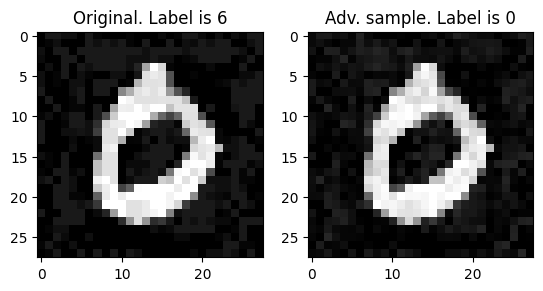


Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample changes after adding the noise.


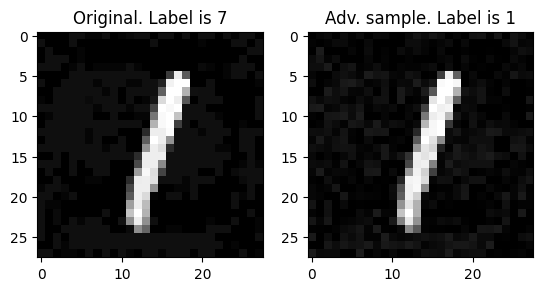


Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample changes after adding the noise.


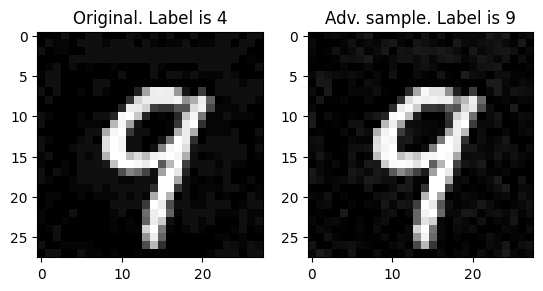


Trying a new adversarial sample.
The label of the adversarial sample changes after adding the noise.


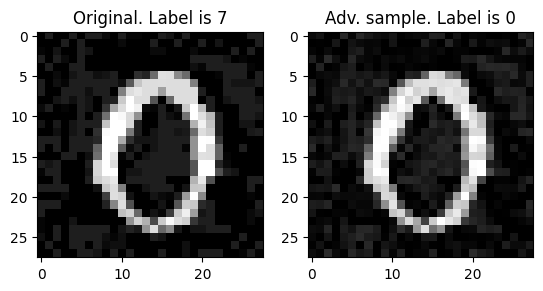


Trying a new adversarial sample.
The label of the adversarial sample changes after adding the noise.


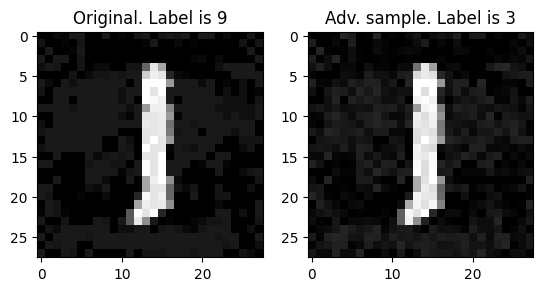


Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample changes after adding the noise.


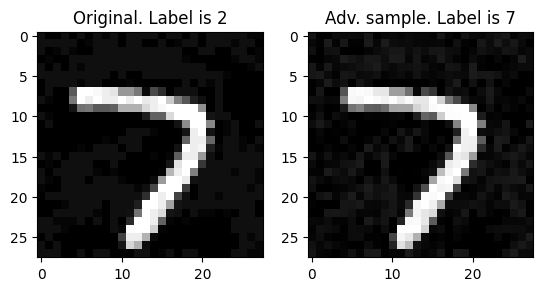


Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
The label of the adversarial sample remains after adding the noise.

Trying a new adversarial sample.
After adding the noise, the number of adversarial samples whose label changes is 6.



In [23]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import numpy as np
import ast


class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x # cross entropy in pytorch already includes softmax
        return output


def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name))

    return model


def denormalize(x):
    x = (x * 255).astype('uint8')
    x = x.reshape(28,28)

    return x


def display(x, y, x_adv, y_adv):
    x = denormalize(x)
    x_adv = denormalize(x_adv)

    fig, ax = plt.subplots(1, 2)

    ax[0].set(title='Original. Label is {}'.format(y))
    ax[1].set(title='Adv. sample. Label is {}'.format(y_adv))

    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(x_adv, cmap='gray')

    plt.show()

# x is the image sample (Tensor), y is the original label (Tensor)
def attack(model, x, y):
    #The following shows one way of introducing some minor modification to
    # the adversarial example, i.e, by adding some uniform noise.
    x_adv = x.detach().clone()
    noise = torch.Tensor(np.random.uniform(-0.05, 0.05, (1,1,28,28)))
    x_adv = torch.clamp(x_adv + noise, 0, 1)

    #TODO: Modify the scale of the noise in the above method and note the
    #number of label changes (repeat each setting for at least 5 times and
    # take the average to reduce the effect of randomness);

    pred_adv = model(x_adv)
    y_adv = pred_adv.argmax(1)

    if y_adv != y:
        print('The label of the adversarial sample changes after adding the noise.')
        x = x.detach().numpy().reshape(-1)
        x_adv = x_adv.detach().numpy().reshape(-1)

        y, y_adv = y.item(), y_adv.item()

        display(x, y, x_adv, y_adv)
        return True
    else:
        print('The label of the adversarial sample remains after adding the noise.')
        return False


model = load_model(MNISTNet, HOME_DIR + 'exercise3/mnist.pt')
changes = 0

num_attack = 20
for i in range(num_attack):
    file_name = HOME_DIR + 'exercise3/toattack_adv/adv_data' + str(i) + '.txt'
    x = np.array(ast.literal_eval(open(file_name, 'r').readline()))
    x = torch.Tensor(x)

    pred = model(x)
    y = pred.argmax(1)
    #print('pred img = {}'.format(pred.detach().numpy().reshape(-1)))

    if attack(model, x, y): changes += 1

    print('\nTrying a new adversarial sample.')

print('After adding the noise, the number of adversarial samples whose label changes is {}.\n'.format(changes))


Exercise 4: In this exercise, we aim to see whether adversarial training with FGSM adversarial attack is effective with FGSM adversarial attacks.

In [35]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import ast

class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x # cross entropy in pytorch already includes softmax
        return output

def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
    return model

def denormalize(x):
    x = (x * 255).astype('uint8')
    x = x.reshape(28,28)
    return x


def display(x, y, x_adv, y_adv):
    x = denormalize(x)
    x_adv = denormalize(x_adv)
    fig, ax = plt.subplots(1, 2)
    ax[0].set(title='Original. Label is {}'.format(y))
    ax[1].set(title='Adv. sample. Label is {}'.format(y_adv))
    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(x_adv, cmap='gray')
    plt.show()

#The following implements FGSM attack.
#x is the image sample (Tensor), y is the original label (Tensor)
def fgsm(model, x, y, eps):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True
    pred = model(x_adv)
    loss = F.cross_entropy(pred, y)
    loss.backward()
    grad_data = x_adv.grad.data
    x_adv = torch.clamp(x_adv + eps * grad_data.sign(), 0, 1).detach()

    pred_adv = model(x_adv)
    y_adv = pred_adv.argmax(1)

    if y_adv != y:
        x = x.detach().numpy().reshape(-1)
        x_adv = x_adv.detach().numpy().reshape(-1)

        y, y_adv = y.item(), y_adv.item()

        print('Attack success: Found an adversarial sample!\n')
        #print('pred adv = {}'.format(pred_adv.detach().numpy().reshape(-1)))
        #print('lbl adv = {}\n'.format(y_adv))
        display(x, y, x_adv, y_adv)
        return True
    else:
        print('Attack unsucessful.\n')
        return False

model = load_model(MNISTNet, HOME_DIR + 'exercise4/mnist.pt')

#TODO：Change the model by replacing the above line with the following one.
# model = load_model(MNISTNet, HOME_DIR + 'exercise4/mnist_robust.pt')
#TODO: Vary the eps below to see the effect with different attacking budget.

# The robust model was trained using adversarial training with FGSM to improve robustness.
# Key details:
# - FGSM configuration: epsilon = 0.03.
# - Training involved both clean and adversarial examples.
# - Adversarial examples were generated on-the-fly during training using the gradient of the loss.
# - Model: Pretrained `MNISTNet` with 4 fully connected layers and ReLU activations.
# - Optimizer: Adam (lr = 0.001), Batch size: 64, Epochs: 30.

num_adv, eps = 0, 0.02

labels = np.array(ast.literal_eval(open(HOME_DIR + 'exercise4/toattack/labels.txt', 'r').readline()))

num_attack = 20
for i in range(num_attack):
    print('Trying a new image.')
    file_name = HOME_DIR + 'exercise4/toattack/data' + str(i) + '.txt'
    x = np.array(ast.literal_eval(open(file_name, 'r').readline()))
    x = torch.Tensor(x)
    y = torch.Tensor([labels[i]]).type(torch.LongTensor)

    pred = model(x)

    if fgsm(model, x, y, eps): num_adv += 1

print('Out of 20 samples, {} are attacked successfully.'.format(num_adv))


Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Trying a new image.
Attack unsucessful.

Out of 20 samples, 0 are attacked successfully.
